# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%cd '/content/drive/MyDrive/GSDS/2022-1/MLDL1/DL/lab/Lab4'

/content/drive/MyDrive/GSDS/2022-1/MLDL1/DL/lab/Lab4


In [3]:
import math
import random
from pathlib import Path
import sys
sys.path.insert(0,str(Path().absolute().joinpath("data")))

from data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


########### import yours ###########
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
####################################

BATCH_SIZE = 64

# TRAIN_RATIO: train dataset ratio, should be a float in (0, 0.8]
# (0.8-TRAIN_RATIO) will be used for valid dataset
TRAIN_RATIO = 0.6 

## Util

**Do NOT Modify** code blocks in this section

In [4]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
def train(model, iterator, optimizer, loss_fn, clip):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch[0].to(device)
        trg = batch[1].to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [6]:
def evaluate(model, iterator, loss_fn):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg)

            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [7]:
MAX_LENGTH = 10
VALID_RATIO = 0.8-TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [8]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length=max_length

        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']
        
        print("data example")
        print(random.choice(self.pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
data example
['tu me fais de l ombre .', 'you re blocking my light .']


# 1. Seq2Seq model with Attention Mechanism

## Implement LSTM Seq2Seq Model

In [9]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim):
        # in_dim: total number of source language tokens
        # emb_dim: size of tokens (256)
        # hid_dim: output vector size(256)
        super(LSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)


    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        some examples below
        - hidden states of encoder

        '''
        ################### YOUR CODE ###################
        embedded = self.embedding.to(device)(input) # (B, max_len, emb_dim)
        hiddens, (hidden, cell) = self.lstm(embedded.to(device), (hidden.to(device), cell.to(device)))
        
        return hiddens, hidden, cell # hiddens: (B, max_len, hid_dim)
        #################################################

In [10]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        # out_dim: total # of target language tokens
        # emb_dim: size of tokens (256)
        # hid_dim: output vector size (256)
        # enc_hidden: output vector
        super(AttnLSTMDecoder, self).__init__()
        
        self.t = 0 # (t)th token decoder
        self.enc_hiddens = enc_hiddens # encoder output (B, hidden)
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.classifier = nn.Linear(hid_dim, out_dim)


    def forward(self, input, hidden, cell):
        
        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention

        INPUT
        - input: input sentence (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (B, n_words of target language), (B, emb_dim), etc.
        - current hidden state
        - current cell state
        '''

        ################### YOUR CODE ###################
        dout = nn.Dropout(p=self.dropout)
        query = hidden # set query to calculate attention (B, hid_dim)
        kv = self.enc_hiddens # (B, MAX_LEN, hid_dim)
        
        attn_score = torch.bmm(kv, query.unsqueeze(1).permute(0, 2, 1)) # (B, MAX_LEN, 1)
        attn_coef = F.softmax(attn_score, dim=1)
        weighted_sum = torch.sum(kv * attn_coef, axis=1)
        attn_value = weighted_sum.unsqueeze(1).to(device)

        input = torch.tensor(input, device='cpu').long()
        embed = dout(self.embedding.to(device)(input.to(device))) # (B, 1, emb_dim)
        concat = torch.concat([embed.to(device), attn_value], dim=2).to(device) # (B, 1, emb_dim+hid_dim)

        dec_out, (hidden, cell) = self.lstm(concat, (hidden.unsqueeze(0).to(device), cell.to(device)))
        y_hat = self.classifier(hidden).to(device)

        self.t += 1 # update time for each forward

        return y_hat, hidden, cell
        #################################################


In [11]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = dropout
        
        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        # - output of one-hot prediction (B, out_dim, max_len)
        - output of token prediction (B, out_dim, max_len)
        '''
        batch_size, mx_len = src.shape
        ################### YOUR CODE ###################

        hidden_0 = torch.zeros(1, batch_size, self.hid_dim)
        cell_0 = torch.zeros(1, batch_size, self.hid_dim)
        enc_hiddens, enc_hidden, enc_cell = self.encoder.forward(src, hidden_0, cell_0)
        
        # Decoder
        self.decoder.enc_hiddens = enc_hiddens # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        
        input = trg[:, 0].unsqueeze(1)
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            y_hat, enc_hidden, enc_cell = self.decoder.forward(input, enc_hidden.squeeze(0), enc_cell)
            outputs[t] = y_hat.squeeze()
            input = trg[:, t].unsqueeze(1)
        
        self.decoder.t=0 # after for loop, reset decoder's time to evaluate properly

        # return F.log_softmax(outputs).permute(1, 2, 0)
        return F.log_softmax(outputs, dim=2).permute(1, 2, 0)
        # return None
        ################### YOUR CODE ###################

## Training

In [12]:
'''
Q2 - (c)
Train your Seq2Seq model and plot losses and perplexities.
Upon successful training, the test perplexity should be less than 5.
You may use visualization libraries for plotting and modify training options such as hyperparameters and optimizer.

'''

'\nQ2 - (c)\nTrain your Seq2Seq model and plot losses and perplexities.\nUpon successful training, the test perplexity should be less than 5.\nYou may use visualization libraries for plotting and modify training options such as hyperparameters and optimizer.\n\n'

In [13]:
# in_dim = dataset.input_lang.n_words
# out_dim = dataset.output_lang.n_words
# hid_dim = 256
# emb_dim = 256
# dropout = 0.5
# learning_rate=1e-3
# N_EPOCHS = 40
# valid_every = 1
# best_valid_loss = float('inf')

# model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

In [14]:
# Train your model
param_dict = dict()
param_list = ["learning_rate", "learning_rate", "dropout", "dropout"]
value_list = [0.005, 0.001, 0.1, 0.7]

for param, val in zip(param_list, value_list):
    in_dim = dataset.input_lang.n_words
    out_dim = dataset.output_lang.n_words
    hid_dim = 256
    emb_dim = 256
    
    if param == "dropout":
        dropout = val
    else:
        dropout = 0.5

    if param == "learning_rate":
        learning_rate = val
    else:
        learning_rate=1e-3
    
    N_EPOCHS = 50
    valid_every = 1
    best_valid_loss = float('inf')

    model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

    t_loss = []
    val_loss = []

    for epoch in range(N_EPOCHS):
        
        train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
        
        print(f'Epoch: {epoch+1:02}')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        
        if epoch % valid_every==0:
            print("==========================")
            valid_loss = evaluate(model, valid_dataloader, loss_fn)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                model.decoder.t=0
                torch.save(model.state_dict(), 'lstm-attn-model.pt')

            # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        t_loss.append(train_loss)
        val_loss.append(valid_loss)
    
    key = f"{param}={val}"
    param_dict[key] = (t_loss, val_loss)

    loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
    loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

    test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
	 Test. Loss: 2.359 |  Test. PPL:  10.586
Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 4

In [15]:
# Test your model

loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Test. Loss: 2.358 |  Test. PPL:  10.573


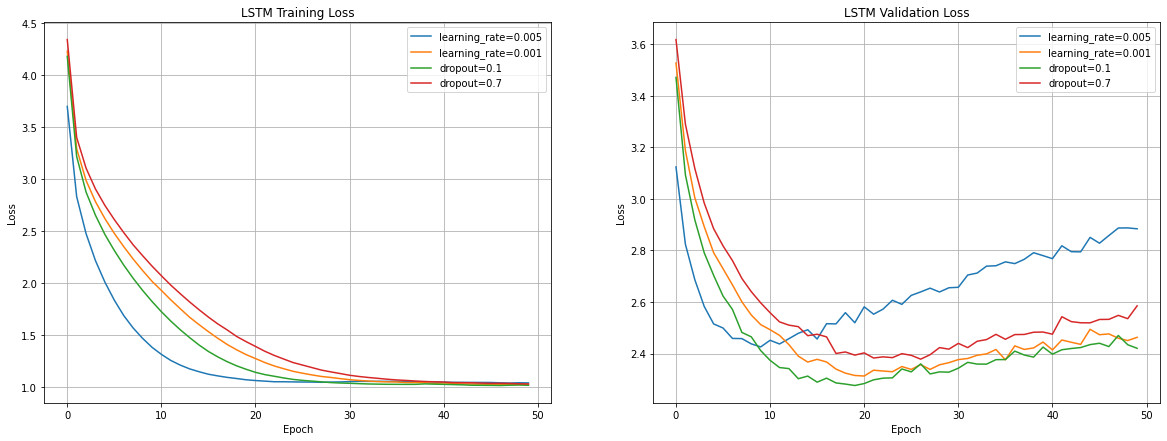

In [16]:
# 그래프 그리기
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
for key in param_dict:
    train_loss, val_loss = param_dict[key]
    ax1.plot(train_loss, label=key)
    ax1.set_title("LSTM Training Loss")
    ax1.grid(True)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(val_loss, label=key)
    ax2.set_title("LSTM Validation Loss")
    ax2.grid(True)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

plt.show()

## [Bonus] Implement GRU Seq2Seq Model

In [17]:
'''
Q2 - (d)
Change the modules(encoder, decoder) in Seq2Seq model to GRU, and repeat (a)~(c).

'''

'\nQ2 - (d)\nChange the modules(encoder, decoder) in Seq2Seq model to GRU, and repeat (a)~(c).\n\n'

In [18]:
class GRUEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(GRUEncoder, self).__init__()
        ################### YOUR CODE ###################

        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)
        #################################################

    def forward(self, input, hidden):

        ################### YOUR CODE ###################
        embedded = self.embedding.to(device)(input) # (B, max_len, emb_dim)
        hiddens, hidden = self.gru(embedded.to(device), hidden.to(device))
        
        return hiddens, hidden # hiddens: (B, max_len, hid_dim)
        #################################################

In [19]:
class AttnGRUDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnGRUDecoder, self).__init__()
        
        ################### YOUR CODE ###################
        self.t = 0 # (t)th token decoder
        self.enc_hiddens = enc_hiddens # encoder output (B, hidden)
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.gru = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.classifier = nn.Linear(hid_dim, out_dim)
        #################################################

    def forward(self, input, hidden):

        ################### YOUR CODE ###################
        dout = nn.Dropout(p=self.dropout)
        query = hidden # set query to calculate attention (B, hid_dim)
        kv = self.enc_hiddens # (B, MAX_LEN, hid_dim)
        
        attn_score = torch.bmm(kv, query.unsqueeze(1).permute(0, 2, 1)) # (B, MAX_LEN, 1)
        attn_coef = F.softmax(attn_score, dim=1)
        weighted_sum = torch.sum(kv * attn_coef, axis=1)
        attn_value = weighted_sum.unsqueeze(1).to(device)

        input = torch.tensor(input, device='cpu').long()
        embed = dout(self.embedding.to(device)(input.to(device))) # (B, 1, emb_dim)
        concat = torch.concat([embed.to(device), attn_value], dim=2).to(device) # (B, 1, emb_dim+hid_dim)

        dec_out, hidden = self.gru(concat, hidden.unsqueeze(0).to(device))
        y_hat = self.classifier(hidden).to(device)

        self.t += 1 # update time for each forward

        return y_hat, hidden
        #################################################


In [20]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(GRUSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = dropout
        
        self.encoder = GRUEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnGRUDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        
        batch_size, mx_len = src.shape
        ################### YOUR CODE ###################
        
        # Encoder
        hidden_0 = torch.zeros(1, batch_size, self.hid_dim)
        enc_hiddens, enc_hidden = self.encoder.forward(src, hidden_0)
        
        # Decoder
        self.decoder.enc_hiddens = enc_hiddens # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        
        input = trg[:, 0].unsqueeze(1)
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            y_hat, enc_hidden = self.decoder.forward(input, enc_hidden.squeeze(0))
            outputs[t] = y_hat.squeeze()
            input = trg[:, t].unsqueeze(1)
        
        self.decoder.t=0 # after for loop, reset decoder's time to evaluate properly

        # return F.log_softmax(outputs).permute(1, 2, 0)
        return F.log_softmax(outputs, dim=2).permute(1, 2, 0)
        #################################################

In [21]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
emb_dim = 256
dropout = 0.5
learning_rate=1e-3
# N_EPOCHS = 40
valid_every = 1
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    
    train_loss = train(gru_model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(gru_model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            gru_model.decoder.t=0
            torch.save(gru_model.state_dict(), 'gru-attn-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01
	Train Loss: 4.137 | Train PPL:  62.599
	 Val. Loss: 3.457 |  Val. PPL:  31.732
Epoch: 02
	Train Loss: 3.214 | Train PPL:  24.890
	 Val. Loss: 3.139 |  Val. PPL:  23.083
Epoch: 03
	Train Loss: 2.899 | Train PPL:  18.160
	 Val. Loss: 2.943 |  Val. PPL:  18.973
Epoch: 04
	Train Loss: 2.682 | Train PPL:  14.621
	 Val. Loss: 2.827 |  Val. PPL:  16.893
Epoch: 05
	Train Loss: 2.507 | Train PPL:  12.273
	 Val. Loss: 2.740 |  Val. PPL:  15.486
Epoch: 06
	Train Loss: 2.355 | Train PPL:  10.536
	 Val. Loss: 2.672 |  Val. PPL:  14.463
Epoch: 07
	Train Loss: 2.222 | Train PPL:   9.226
	 Val. Loss: 2.604 |  Val. PPL:  13.514
Epoch: 08
	Train Loss: 2.096 | Train PPL:   8.137
	 Val. Loss: 2.552 |  Val. PPL:  12.837
Epoch: 09
	Train Loss: 1.980 | Train PPL:   7.243
	 Val. Loss: 2.500 |  Val. PPL:  12.177
Epoch: 10
	Train Loss: 1.874 | Train PPL:   6.512
	 Val. Loss: 2.471 |  Val. PPL:  11.834
Epoch: 11
	Train Loss: 1.778 | Train PPL:   5.917
	 Val. Loss: 2.461 |  Val. PPL:  11.714
Epoch: 12


In [22]:
loaded_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('gru-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	 Test. Loss: 2.322 |  Test. PPL:  10.195


In [29]:
# Train your model
gru_param_dict = dict()
param_list = ["learning_rate", "learning_rate", "dropout", "dropout"]
value_list = [0.005, 0.001, 0.1, 0.7]

for param, val in zip(param_list, value_list):
    in_dim = dataset.input_lang.n_words
    out_dim = dataset.output_lang.n_words
    hid_dim = 256
    emb_dim = 256
    
    if param == "dropout":
        dropout = val
    else:
        dropout = 0.5

    if param == "learning_rate":
        learning_rate = val
    else:
        learning_rate=1e-3
    
    N_EPOCHS = 60
    valid_every = 1
    best_valid_loss = float('inf')

    model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

    t_loss = []
    val_loss = []

    for epoch in range(N_EPOCHS):
        
        train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
        
        print(f'Epoch: {epoch+1:02}')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        
        if epoch % valid_every==0:
            print("==========================")
            valid_loss = evaluate(model, valid_dataloader, loss_fn)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                model.decoder.t=0
                torch.save(model.state_dict(), 'gru-attn-model.pt')

            # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        t_loss.append(train_loss)
        val_loss.append(valid_loss)
    
    key = f"{param}={val}"
    gru_param_dict[key] = (t_loss, val_loss)

    loaded_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
    loaded_model.load_state_dict(torch.load('gru-attn-model.pt'))

    test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
	 Test. Loss: 2.458 |  Test. PPL:  11.676
Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 3

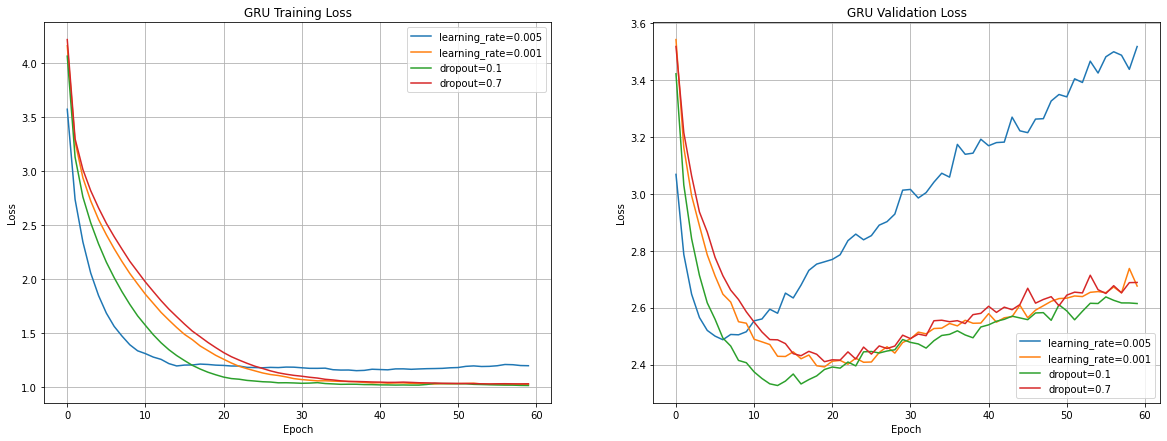

In [30]:
# 그래프 그리기
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
for key in gru_param_dict:
    train_loss, val_loss = gru_param_dict[key]
    ax1.plot(train_loss, label=key)
    ax1.set_title("GRU Training Loss")
    ax1.grid(True)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(val_loss, label=key)
    ax2.set_title("GRU Validation Loss")
    ax2.grid(True)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

plt.show()

* From the figures above, we can understand several points below:
    - Controlling the dropout layer is more effective in decreasing loss than controlling the learning rate is. Furthermore, as we drop more nodes out of the layer, the performance of the model becomes worse.
    - Every model with each hyper-parameter showed overfitting after a certain epoch, around 15 ~ 20 specifically.
    - In terms of convergence rate, the GRU was faster than the LSTM. For example, when the dropout rate is 0.1, the training loss of the GRU was lower than that of the LSTM at the same epoch, e.g., epoch 10.
    - While in terms of overfitting, we can say that the LSTM is more robust than the GRU, since the rate of divergence of loss was faster in the GRU than in the LSTM, when the learning rate was set at 0.005.
    - Therefore, we can conclude that the GRU is recommended when we want faster convergence.

# 2. Seq2Seq model with Transformer

## Implement Transformer Seq2Seq Model

In [25]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()

        self.hid_dim = hid_dim
        self.max_length = max_length

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        encoder_layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, src, pos_emb, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransEncoder Module
        (Use torch.nn.TransformerEncoder, torch.nn.TransformerEncoderLayer)
        
        INPUT
        - src: source language batched data (B, max_len)
        - pos_emb: positional embedding (max_len, hid_dim)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - encoder output (B, max_len, hid_dim)
        '''
        batch_size, src_len = src.shape
        #################### YOUR CODE ####################
        src_emb = self.tok_embedding(src) # (B, max_len, hid_dim)
        src_emb += pos_emb

        output = self.encoder(src_emb, src_key_padding_mask=src_mask.reshape(src_len, batch_size))
        return output
        ###################################################

In [26]:
class TransDecoder(nn.Module):
    def __init__(self, out_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.max_length = max_length
        
        self.tok_embedding = nn.Embedding(out_dim, hid_dim)
        
        decoder_layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, n_layers)
        
        self.fc_out = nn.Linear(hid_dim, out_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, trg, pos_emb, enc_src, trg_mask, trg_sub_mask, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransDecoder Module
        (Use torch.nn.TransformerDecoder, torch.nn.TransformerDecoderLayer)
        
        INPUT
        - trg: target language batched data (B, max_len)
        - pos_emb: positional embedding (max_len, hid_dim)
        - enc_src: encoder outputs (B, max_len, hid_dim)
        - trg_mask: padding mask tensor for target sentences (B, max_len)
        - trg_sub_mask: subsequent mask for target sentences (max_len, max_len)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - decoder output (B, max_len, out_dim)
        '''
        batch_size, trg_len = trg.shape

        #################### YOUR CODE ####################
        # src_emb = self.tok_embedding(src) # (B, max_len, hid_dim)
        # src_emb += pos_emb

        # output = self.encoder(src_emb, src_key_padding_mask=src_mask.reshape(src_len, batch_size))
        # return output

        tgt_emb = self.tok_embedding(trg)
        tgt_emb += pos_emb
        output = self.decoder(tgt_emb, enc_src, tgt_mask=trg_mask.reshape(trg_len, batch_size), 
                              memory_mask=src_mask.reshape(trg_len, batch_size), 
                              tgt_key_padding_mask=trg_sub_mask)

        return output
        ###################################################

In [27]:
class TransSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout_p, device, max_length=MAX_LENGTH):
        super().__init__()
        
        self.device = device
        self.hid_dim = hid_dim
        self.max_length = max_length

        self.encoder = TransEncoder(in_dim, hid_dim, n_layers[0], n_heads, ff_dim, dropout_p, device)
        self.decoder = TransDecoder(out_dim, hid_dim, n_layers[1], n_heads, ff_dim, dropout_p, device)
        
    def make_src_mask(self, src):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - src: batched input sentences (B, max_len)

        OUTPUT
        - Boolean padding mask tensor (B, max_len)
        '''
        #################### YOUR CODE ####################
        src_mask = (src != dataset.input_lang_pad).unsqueeze(-2)

        return src_mask
        ###################################################

    def make_trg_mask(self, trg):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - trg: batched target sentences (B, max_len)

        OUTPUT
        - A tuple of a padding mask tensor and a subsequent mask tensor ((B, max_len), (max_len, max_len))
        '''
        #################### YOUR CODE ####################
        trg_mask = (trg != dataset.output_lang_pad).unsqueeze(1)
        sub_mask = torch.tril(torch.ones(1, self.max_length, self.max_length)).bool()
        trg_mask = trg_mask & sub_mask

        return trg_mask, sub_mask
        ###################################################

    def forward(self, src, trg):
        '''
        Q3 - (c)
        Implement forward method of TransSeq2Seq Module
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - decoder output (B, out_dim, max_dim)
        
        '''
        #################### YOUR CODE ####################

        return None
        ###################################################
    
    
    def get_pos_emb(self):
        '''
        Q3 - (a)
        Implement absolute positional embedding

        OUTPUT
        - positional embedding tensor (max_len, hid_dim)
        '''
        #################### YOUR CODE ####################
        enc = torch.zeros(self.max_length, self.hid_dim).to(device)

        for pos in range(self.max_length):
            for i in range(0, self.hid_dim, 2):
                enc[pos, i] = torch.sin(pos / 10000**(2*i / self.hid_dim))
                enc[pos, i+1] = torch.sin(pos / 10000**(2*(i+1) / self.hid_dim))
        
        enc = enc.unsqueeze(0)

        return enc
        ###################################################

In [28]:
X = torch.randn(3, 4)
y = torch.randn(3, 4)

X & y

RuntimeError: ignored

In [ ]:
B = 10
len = 20

X = (torch.randn(10, 20) != dataset.output_lang_pad).unsqueeze(-2)
print(X.shape)
dataset.output_lang_pad

## Training

In [ ]:
'''
Q3 - (d)
Train your Seq2Seq model and plot losses and perplexities.
Upon successful training, the test perplexity should be less than 2.
You may use visualization libraries for plotting and modify training options such as hyperparameters and optimizer.

Based on the results from lSTM(GRU)-based and transformer-based Seq2Seq models,
briefly describe which approach is better and why.
'''

In [ ]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
ff_dim = 1024
n_enc_layers = 4
n_dec_layers = 4
n_layers = [n_enc_layers, n_dec_layers]
n_heads = 8
dropout = 0.1

learning_rate=1e-2
N_EPOCHS = 100
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)
# print(model)

In [ ]:
# Train your model
for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'transformer-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# Test your model
loaded_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
loaded_model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')